## DDPM Code

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.training_utils import EMAModel
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
from diffusers import DDPMPipeline

/home/3782/.conda/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# CONFIG 
H5_PATH = "./MICRO2D_homogenized.h5"  # ← Replace this with your file path
CLASS_NAME = "NBSA"
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_INTERVAL = 10 # Generate samples every 10 epochs

In [ ]:
# DATASET 
class Micro2DDataset(Dataset):
    def __init__(self, h5_path, group='GRF', transform=None):
        self.f = h5py.File(h5_path, 'r')
        self.data = self.f[group][group]  # Correct path: e.g., 'GRF/GRF'
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][()]  # numpy array (256, 256)
        if self.transform:
            image = self.transform(image)
        return image

# TRANSFORM 
image_transforms = transforms.Compose([
    transforms.ToTensor(),                    # shape: (1, 256, 256), dtype: float32
    transforms.Lambda(lambda x: x.float()),   # make sure it's float32
    transforms.Lambda(lambda x: x * 2 - 1),   # scale to [-1, 1]
])

In [ ]:
# PLOTTING FUNCTION 
def sample_and_plot(pipeline, epoch, device, n_samples=4,threshold=127):
    pipeline.to(device)
    model.eval()
    with torch.no_grad():
        images = pipeline(batch_size=n_samples, generator=torch.manual_seed(42)).images
    model.train()

    fig, axs = plt.subplots(1, n_samples, figsize=(12, 3))
    for i, img in enumerate(images):
        img_np = np.array(img.convert("L"))  # grayscale, shape (256, 256)

        # Apply threshold to binarize 
        binary_img = (img_np > threshold).astype(np.uint8) * 255

        axs[i].imshow(binary_img, cmap="gray")
        axs[i].axis("off")

    plt.suptitle(f"Epoch {epoch} - NBSA GEN")
    plt.tight_layout()
    plt.show()

In [ ]:
# DATA LOADER 
dataset = Micro2DDataset(H5_PATH, group=CLASS_NAME, transform=image_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# MODEL 
model = UNet2DModel(
    sample_size=256,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to(DEVICE)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

  0%|                                                                                                        | 0/205 [00:00<?, ?it/s]/home/3782/.conda/envs/diffusion/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1 | Loss: 0.0095: 100%|██████████████████████████████████████████████████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 2 | Loss: 0.0220: 100%|██████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 3 | Loss: 0.0556: 100%|██████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 4 | Loss: 0.1045

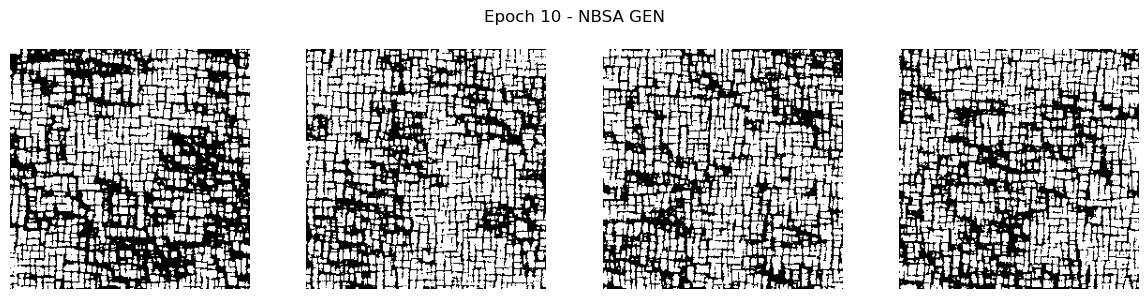

Epoch 11 | Loss: 0.0494: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 12 | Loss: 0.0122: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 13 | Loss: 0.0768: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 14 | Loss: 0.0375: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 15 | Loss: 0.0456: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 16 | Loss: 0.0743: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 17 | Loss: 0.0294: 100%|█████████████████████████████████████████████████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 18 | Loss: 0.0005: 100%|████████████████████████████████

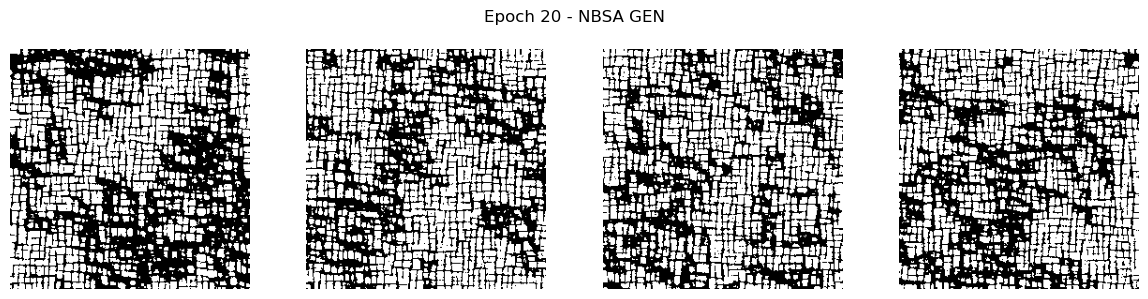

Epoch 21 | Loss: 0.0488: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 22 | Loss: 0.0077: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 23 | Loss: 0.0738: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 24 | Loss: 0.0370: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 25 | Loss: 0.0335: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 26 | Loss: 0.0721: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 27 | Loss: 0.0266: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 28 | Loss: 0.0004: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 29 | Loss: 0.0434: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 30 | Loss: 0.0089: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
100%|██████████████████████████████████████████████████| 1000/1000 [02:30<00:00,

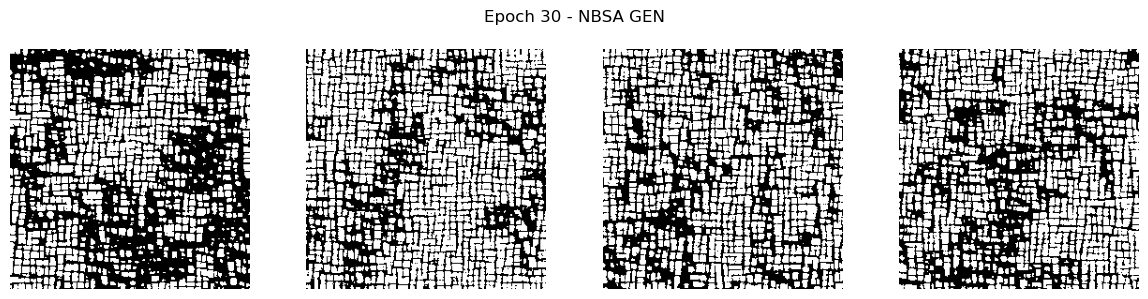

Epoch 31 | Loss: 0.0483: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 32 | Loss: 0.0049: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 33 | Loss: 0.0722: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 34 | Loss: 0.0366: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 35 | Loss: 0.0380: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 36 | Loss: 0.0693: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 37 | Loss: 0.0241: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 38 | Loss: 0.0003: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.15s/it]
Epoch 39 | Loss: 0.0414: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 40 | Loss: 0.0088: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
100%|██████████████████████████████████████████████████| 1000/1000 [02:30<00:00,

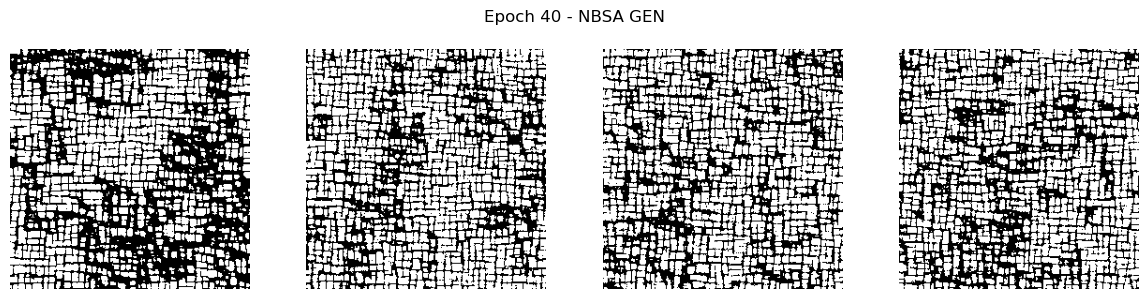

Epoch 41 | Loss: 0.0481: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 42 | Loss: 0.0038: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 43 | Loss: 0.0708: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 44 | Loss: 0.0362: 100%|███████████████████████████| 205/205 [03:56<00:00,  1.16s/it]
Epoch 45 | Loss: 0.0328: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 46 | Loss: 0.0664: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 47 | Loss: 0.0228: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 48 | Loss: 0.0003: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 49 | Loss: 0.0391: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
Epoch 50 | Loss: 0.0088: 100%|███████████████████████████| 205/205 [03:57<00:00,  1.16s/it]
100%|██████████████████████████████████████████████████| 1000/1000 [02:30<00:00,

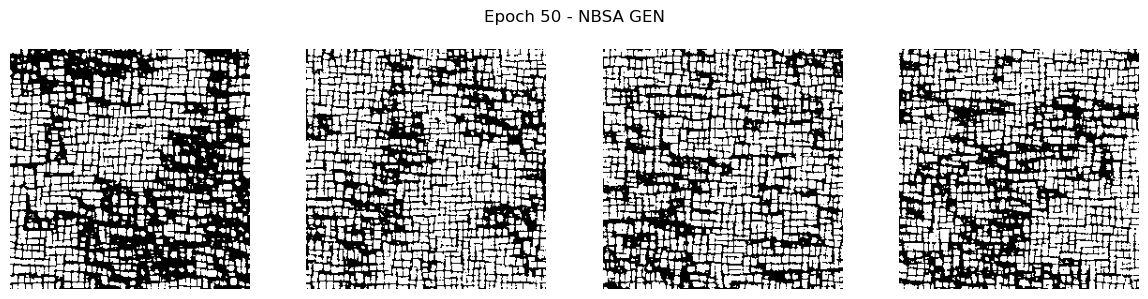

In [ ]:
# TRAINING LOOP 
for epoch in range(EPOCHS):
    pbar = tqdm(dataloader)
    for batch in pbar:
        clean_images = batch.to(DEVICE)
        noise = torch.randn_like(clean_images)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (clean_images.shape[0],), device=DEVICE).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

    # SAMPLE EVERY N EPOCHS 
    if (epoch + 1) % SAMPLE_INTERVAL == 0:
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
        sample_and_plot(pipeline, epoch + 1, DEVICE)
# SAVE MODEL 
torch.save(model.state_dict(), f"./Results/ddpm_micro2d_{CLASS_NAME.lower()}.pt")

## Evaluation for DDPM
Eval metrics - FID, SSIM, Volume Fraction

In [ ]:
import os
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import inception_v3
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from diffusers import UNet2DModel, DDPMScheduler
from skimage.metrics import structural_similarity as ssim
from skimage.measure import label, regionprops
from scipy.signal import correlate2d
from scipy.stats import wasserstein_distance
from tqdm import tqdm
from scipy.linalg import sqrtm

In [ ]:
# CONFIG 
H5_PATH = "./MICRO2D_homogenized.h5"
CLASS_NAME = "NBSA"
MODEL_PATH = "./Results/ddpm_micro2d_nbsa.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_SAMPLES = 16
FID_IMG_SIZE = 299
SAMPLE_SAVE_DIR = "./DDPM_Generated"
os.makedirs(SAMPLE_SAVE_DIR, exist_ok=True)

In [ ]:
#  DATASET 
class Micro2DDataset(Dataset):
    def __init__(self, h5_path, group='GRF', transform=None):
        self.f = h5py.File(h5_path, 'r')
        self.data = self.f[group][group]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][()]
        if self.transform:
            image = self.transform(image)
        return image

#  TRANSFORMS 
transform_real = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Lambda(lambda x: x * 2 - 1)
])

def transform_fid(img):
    if isinstance(img, torch.Tensor):
        if img.ndim == 2:
            img = img.unsqueeze(0)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        img = transforms.Resize((299, 299))(img)
        return img
    else:
        raise ValueError("Expected image as a PyTorch tensor.")

#  LOAD DATA 
real_dataset = Micro2DDataset(H5_PATH, group=CLASS_NAME, transform=transform_real)
real_loader = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=False)

#  LOAD MODEL 
model = UNet2DModel(
    sample_size=256,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
scheduler = DDPMScheduler(num_train_timesteps=1000)

#  GENERATE IMAGES 
def generate_ddpm_samples(model, scheduler, num_images=NUM_SAMPLES):
    all_images = []
    scheduler.set_timesteps(1000)
    for _ in tqdm(range((num_images + BATCH_SIZE - 1) // BATCH_SIZE)):
        noise = torch.randn((BATCH_SIZE, 1, 256, 256), device=DEVICE)
        with torch.no_grad():
            for t in scheduler.timesteps:
                noise = scheduler.step(model(noise, t).sample, t, noise).prev_sample
        images = (noise + 1) / 2
        all_images.append(images.cpu())
    return torch.cat(all_images, dim=0)[:num_images]

gen_images = generate_ddpm_samples(model, scheduler)
for i, img in enumerate(gen_images):
    save_image(img, f"{SAMPLE_SAVE_DIR}/gen_{i}.png")

#  METRIC UTILITIES 
def compute_2pcf(img):
    img = img.astype(np.float32)
    img -= np.mean(img)
    return correlate2d(img, img, mode='full') / (img.shape[0] * img.shape[1])

def get_inception_activations(images, model):
    model.eval()
    activations = []
    with torch.no_grad():
        for img in images:
            img_resized = transform_fid(img.squeeze()).unsqueeze(0).to(DEVICE)
            pred = model(img_resized)
            activations.append(pred.squeeze().cpu().numpy())
    return np.array(activations)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu1 - mu2
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

#  PHYSICAL METRICS 
def physical_metrics(real_loader, generated_images):
    real_imgs = []
    for batch in real_loader:
        real_imgs.append(batch)
        if len(real_imgs) * BATCH_SIZE >= len(generated_images):
            break
    real_imgs = torch.cat(real_imgs, dim=0)[:len(generated_images)].squeeze().numpy()
    gen_imgs = generated_images.squeeze().numpy()

    ssim_scores = []
    vf_real = []
    vf_gen = []

    for real, fake in zip(real_imgs, gen_imgs):
        r_bin = (real > 0).astype(np.uint8)
        f_bin = (fake > 0.5).astype(np.uint8)
        ssim_scores.append(ssim(r_bin, f_bin))
        vf_real.append(r_bin.mean())
        vf_gen.append(f_bin.mean())

    print(f"Avg SSIM: {np.mean(ssim_scores):.4f}")
    print(f"Real Volume Fraction: {np.mean(vf_real):.4f}")
    print(f"Generated Volume Fraction: {np.mean(vf_gen):.4f}")

def plot_2pcf(real_imgs, gen_imgs, sample_size=10):
    real_2pcf = np.mean([compute_2pcf(img) for img in real_imgs[:sample_size]], axis=0)
    gen_2pcf = np.mean([compute_2pcf(img) for img in gen_imgs[:sample_size]], axis=0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(real_2pcf, cmap='hot')
    plt.title("Real 2-Point Correlation")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gen_2pcf, cmap='hot')
    plt.title("Generated 2-Point Correlation")
    plt.axis("off")
    plt.show()

def histogram_analysis(real_imgs, gen_imgs):
    real_hist = np.mean([np.histogram(img, bins=10, range=(0, 1))[0] for img in real_imgs], axis=0)
    gen_hist = np.mean([np.histogram(img, bins=10, range=(0, 1))[0] for img in gen_imgs], axis=0)

    plt.plot(real_hist, label="Real")
    plt.plot(gen_hist, label="Generated")
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Bin")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    wd = wasserstein_distance(real_hist, gen_hist)
    print(f"Wasserstein Distance between histograms: {wd:.4f}")

def morphological_metrics(images, label_name="Generated"):
    porosity = []
    grain_sizes = []
    aspect_ratios = []
    euler_numbers = []

    for img in images:
        props = regionprops(label(img))
        grain_sizes.extend([p.area for p in props])
        aspect_ratios.extend([p.major_axis_length / p.minor_axis_length if p.minor_axis_length > 0 else 0 for p in props])
        porosity.append(1.0 - img.mean())
        euler_numbers.append(len(props))

    print(f"\n[{label_name} Morphology]")
    print(f"Avg Porosity: {np.mean(porosity):.4f}")
    print(f"Avg Grain Size: {np.mean(grain_sizes):.2f}")
    print(f"Avg Aspect Ratio: {np.mean(aspect_ratios):.2f}")
    print(f"Euler Number (connected regions): {np.mean(euler_numbers):.2f}")

#  PREPARE BINARY IMAGES 
gen_imgs_bin = (gen_images.squeeze().numpy() > 0.5).astype(np.uint8)
real_imgs_bin = []
for batch in real_loader:
    real_imgs_bin.append((batch.squeeze().numpy() > 0).astype(np.uint8))
    if len(real_imgs_bin) * BATCH_SIZE >= len(gen_imgs_bin):
        break
real_imgs_bin = np.concatenate(real_imgs_bin, axis=0)[:len(gen_imgs_bin)]

In [ ]:
#  INCEPTION FEATURES & FID 
inception = inception_v3(weights="IMAGENET1K_V1", transform_input=False).to(DEVICE)
inception.fc = torch.nn.Identity()

real_imgs_fid = [transform_fid((img + 1) / 2) for img in real_dataset[:NUM_SAMPLES]]
gen_imgs_fid = [transform_fid(img) for img in gen_images]

act_real = get_inception_activations(real_imgs_fid, inception)
act_gen = get_inception_activations(gen_imgs_fid, inception)

mu_real, sigma_real = act_real.mean(0), np.cov(act_real, rowvar=False)
mu_gen, sigma_gen = act_gen.mean(0), np.cov(act_gen, rowvar=False)

fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"\nFID Score: {fid:.4f}")

#  FULL METRIC REPORT 
physical_metrics(real_loader, gen_images)
plot_2pcf(real_imgs_bin, gen_imgs_bin)
histogram_analysis(real_imgs_bin, gen_imgs_bin)
morphological_metrics(real_imgs_bin, "Real")
morphological_metrics(gen_imgs_bin, "Generated")


/tmp/ipykernel_88297/1545156794.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
 50%|████████████████